In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install geopandas matplotlib requests xarray rasterio rioxarray shapely


In [14]:
# Required packages for data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt

# Required for HTTP requests
import requests

# Required for working with multi-dimensional arrays and netCDF files
import xarray as xr
import os

# Required for spatial data manipulation
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping
from pyproj import CRS, Proj


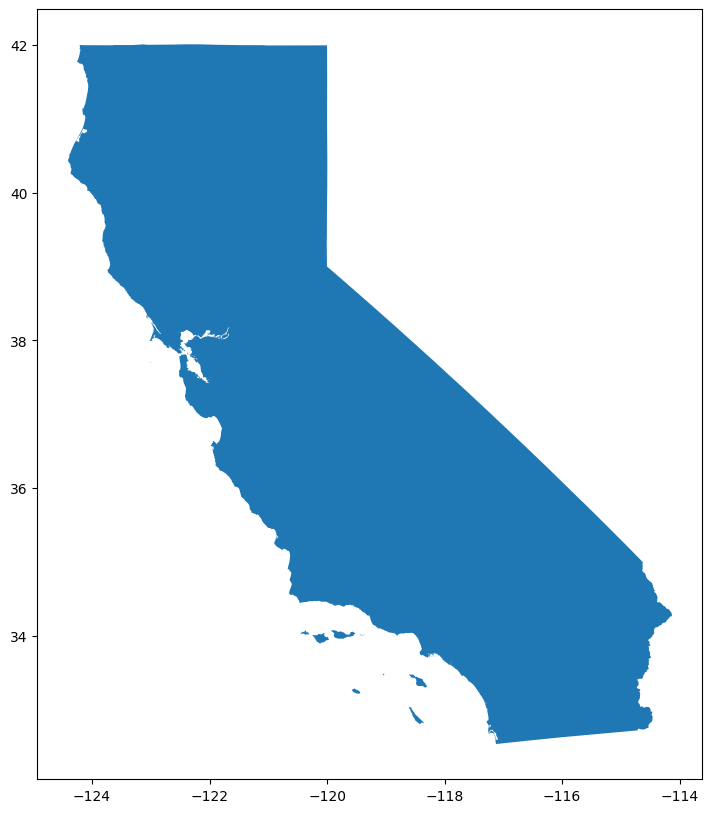

In [4]:
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax)
plt.show()


In [25]:
# Step 1: Extract dataset-specific links from the THREDDS Catalog
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Filter the links to include only those that point to dataset-specific pages with 'prcp_monttl_pr'
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/' + link['href'] for link in links if 'dataset=' in link['href'] and 'prcp_monttl_pr' in link['href']]


In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Extract dataset-specific links from the THREDDS Catalog
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Extract unique dataset options
dataset_options = set()
for link in links:
    href = link['href']
    if 'dataset=' in href and 'daymet_v4_' in href:
        dataset_name = href.split('=')[-1]
        option = dataset_name.replace('daymet_v4_', '').rsplit('_', 1)[0]
        dataset_options.add(option)

# Display options to the user
print("Available dataset options:")
for i, option in enumerate(sorted(dataset_options), start=1):
    print(f"{i}. {option}")

# Get user's choice
user_choice = int(input("Enter the number of the dataset you want to choose: ")) - 1
selected_option = sorted(dataset_options)[user_choice]

# Filter the links based on user's choice
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=' + link['href'].split('=')[-1] for link in links if 'dataset=' in link['href'] and selected_option in link['href'].replace('daymet_v4_', '').rsplit('_', 1)[0]]

# Convert the links to a DataFrame for further filtering if necessary
df = pd.DataFrame(dataset_links, columns=['Links'])

# Show the selected dataset links
print("\nSelected dataset links:")
print(df)


Available dataset options:
1. 2131/prcp_monttl_hi
2. 2131/prcp_monttl_na
3. 2131/prcp_monttl_pr
4. 2131/swe_monavg_hi
5. 2131/swe_monavg_na
6. 2131/swe_monavg_pr
7. 2131/tmax_monavg_hi
8. 2131/tmax_monavg_na
9. 2131/tmax_monavg_pr
10. 2131/tmin_monavg_hi
11. 2131/tmin_monavg_na
12. 2131/tmin_monavg_pr
13. 2131/vp_monavg_hi
14. 2131/vp_monavg_na
15. 2131/vp_monavg_pr
Enter the number of the dataset you want to choose: 10

Selected dataset links:
                                                Links
0   https://thredds.daac.ornl.gov/thredds/catalog/...
1   https://thredds.daac.ornl.gov/thredds/catalog/...
2   https://thredds.daac.ornl.gov/thredds/catalog/...
3   https://thredds.daac.ornl.gov/thredds/catalog/...
4   https://thredds.daac.ornl.gov/thredds/catalog/...
5   https://thredds.daac.ornl.gov/thredds/catalog/...
6   https://thredds.daac.ornl.gov/thredds/catalog/...
7   https://thredds.daac.ornl.gov/thredds/catalog/...
8   https://thredds.daac.ornl.gov/thredds/catalog/...
9   https:/

In [69]:
# Show the selected dataset links
print("\nSelected dataset links:")
for i, row in df.iterrows():
    print(f"{i+1}. {row['Links']}")



Selected dataset links:
1. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1980.nc
2. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1981.nc
3. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1982.nc
4. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1983.nc
5. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1984.nc
6. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1985.nc
7. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1986.nc
8. https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_tmin_monavg_hi_1987.nc

In [27]:
# Base URL for the THREDDS file server
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Initialize an empty list to store the xarray datasets
datasets = []

# Create a directory to store the downloaded NetCDF files
os.makedirs('netcdf_files', exist_ok=True)

# Loop through each dataset URL
for i, data_url in enumerate(dataset_links, start=1):
    # Extract the NetCDF file name from the URL
    nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

    # Construct the direct URL to the NetCDF file
    direct_url = base_url + nc_filename

    print(f"Downloading dataset {i}/{len(dataset_links)}: {direct_url}")

    # Download the dataset
    response = requests.get(direct_url)
    if response.status_code != 200:
        print(f"Failed to download dataset {i}: HTTP status code {response.status_code}")
        continue

    filename = f'netcdf_files/{nc_filename}'

    with open(filename, 'wb') as f:
        f.write(response.content)

    # Check if the file is downloaded correctly
    file_size = os.path.getsize(filename)
    print(f"File size of dataset {i}: {file_size} bytes")
    if file_size == 0:
        print(f"Failed to download dataset {i}: The file is empty")
        continue

    # Load the dataset and add it to the list
    try:
        ds = xr.open_dataset(filename)
        datasets.append(ds)
        print(f"Dataset {i} loaded successfully")
    except Exception as e:
        print(f"Failed to load dataset {i}: {str(e)}")

print("All datasets processed.")
print(f"Number of successfully loaded datasets: {len(datasets)}")


File size of dataset 1: 982605 bytes
Dataset 1 loaded successfully
File size of dataset 2: 967933 bytes
Dataset 2 loaded successfully
File size of dataset 3: 983677 bytes
Dataset 3 loaded successfully
File size of dataset 4: 980908 bytes
Dataset 4 loaded successfully
File size of dataset 5: 981045 bytes
Dataset 5 loaded successfully
File size of dataset 6: 983679 bytes
Dataset 6 loaded successfully
File size of dataset 7: 992616 bytes
Dataset 7 loaded successfully
File size of dataset 8: 982648 bytes
Dataset 8 loaded successfully
File size of dataset 9: 988343 bytes
Dataset 9 loaded successfully
File size of dataset 10: 988629 bytes
Dataset 10 loaded successfully
File size of dataset 11: 996859 bytes
Dataset 11 loaded successfully
File size of dataset 12: 989233 bytes
Dataset 12 loaded successfully
File size of dataset 13: 986692 bytes
Dataset 13 loaded successfully
File size of dataset 14: 990969 bytes
Dataset 14 loaded successfully
File size of dataset 15: 979410 bytes
Dataset 15 loa

In [54]:
# single dataset for testing:

# Base URL for the THREDDS file server
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Initialize an empty list to store the xarray datasets
datasets = []

# Create a directory to store the downloaded NetCDF files
os.makedirs('netcdf_files', exist_ok=True)

# Extract the first dataset URL
data_url = dataset_links[0]

# Extract the NetCDF file name from the URL
nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

# Construct the direct URL to the NetCDF file
direct_url = base_url + nc_filename

print(f"Downloading dataset: {direct_url}")

# Download the dataset
response = requests.get(direct_url)
if response.status_code == 200:
    filename = f'netcdf_files/{nc_filename}'

    with open(filename, 'wb') as f:
        f.write(response.content)

    # Check if the file is downloaded correctly
    file_size = os.path.getsize(filename)
    print(f"File size of dataset: {file_size} bytes")
    if file_size > 0:
        # Load the dataset and add it to the list
        try:
            ds = xr.open_dataset(filename)
            datasets.append(ds)
            print("Dataset loaded successfully")
        except Exception as e:
            print(f"Failed to load dataset: {str(e)}")
    else:
        print("Failed to download dataset: The file is empty")
else:
    print(f"Failed to download dataset: HTTP status code {response.status_code}")

print("All datasets processed.")
print(f"Number of successfully loaded datasets: {len(datasets)}")

IndexError: ignored

Dataset CRS: None
California Bounding Box: minx   -1.950919e+06
miny   -9.242346e+05
maxx   -1.249723e+06
maxy    2.227144e+05
Name: 4, dtype: float64


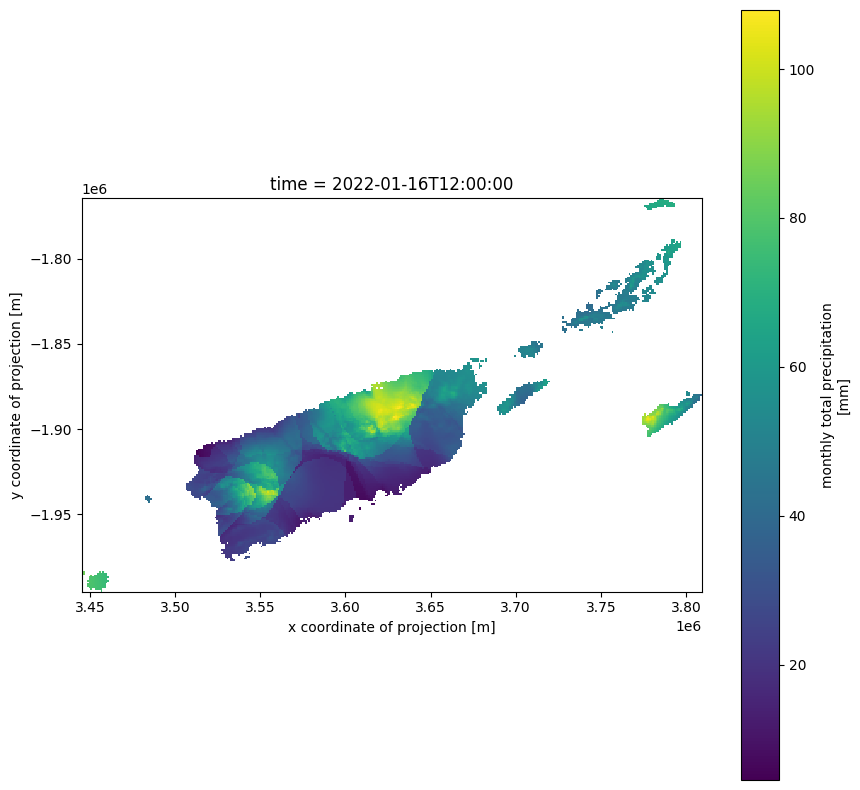

In [53]:
import geopandas as gpd
from pyproj import CRS, Proj
import rioxarray
import matplotlib.pyplot as plt

# Load your Daymet dataset here
# ds = ...

# Define the Lambert Conformal Conic projection used by Daymet
lcc_proj = Proj(proj='lcc', datum='WGS84', lat_1=25, lat_2=60, lat_0=42.5, lon_0=-100, x_0=0, y_0=0, units='m')
dataset_crs = CRS(lcc_proj.srs)

# Load your California shapefile here
# california = ...

# Reproject the California shapefile to the dataset's coordinate system
california = california.to_crs(dataset_crs)

# Set the spatial dimensions of the dataset
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

# Check the CRS of the dataset
print("Dataset CRS:", ds.rio.crs)

# Check the bounding box coordinates of California
print("California Bounding Box:", california.bounds.iloc[0])

# Visualize the data and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
ds['prcp'].isel(time=0).plot(ax=ax)
california.boundary.plot(ax=ax, color='r')
plt.show()


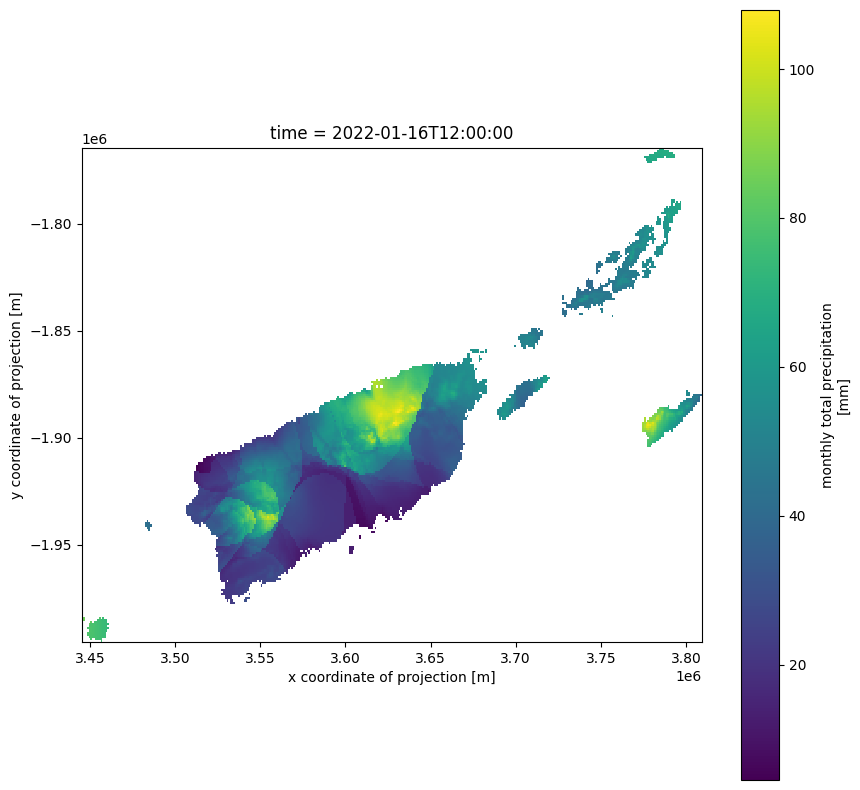

In [42]:
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

# Load your Daymet dataset here
# ds = ...

# Load your California shapefile here
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']

# Set the spatial dimensions of the dataset
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
ds['prcp'].isel(time=0).plot(ax=ax, cmap='viridis')
california.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
plt.show()


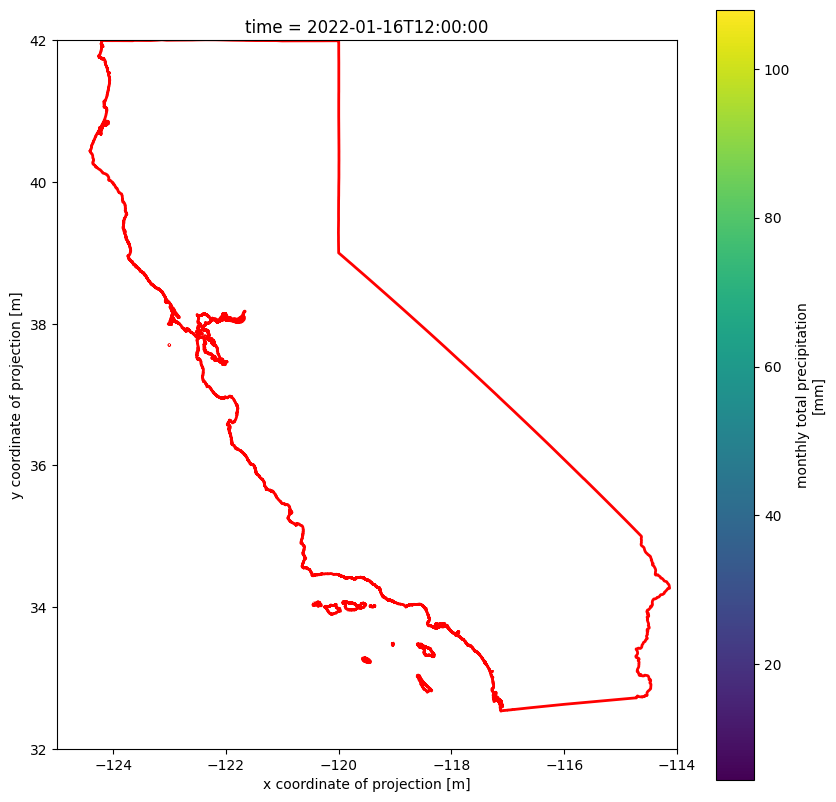

In [43]:
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

# Load your Daymet dataset here
# ds = ...

# Load your California shapefile here
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']

# Set the spatial dimensions of the dataset
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
ds['prcp'].isel(time=0).plot(ax=ax, cmap='viridis')

# Increase line width and change border color
california.boundary.plot(ax=ax, linewidth=2, edgecolor='red')

# Set plot limits to focus on California
ax.set_xlim([-125, -114])
ax.set_ylim([32, 42])

plt.show()


KeyError: ignored

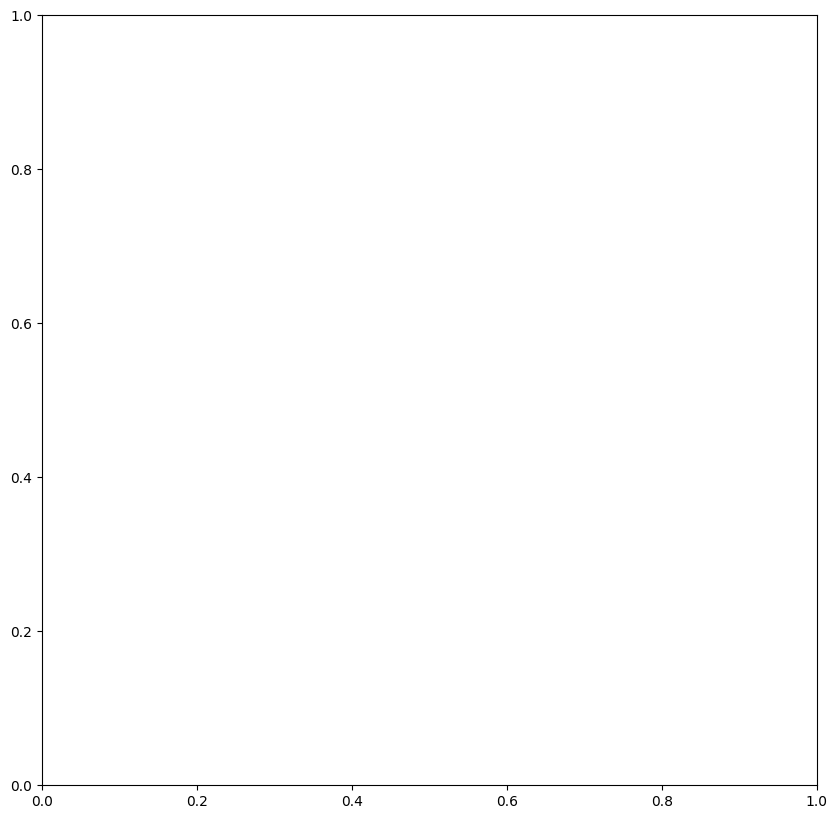

In [44]:
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

# Load your Daymet dataset here
# ds = ...

# Load your California shapefile here
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']

# Set the spatial dimensions of the dataset
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
ds['tmax'].isel(time=0).plot(ax=ax, cmap='viridis')

# Increase line width and change border color
california.boundary.plot(ax=ax, linewidth=2, edgecolor='red')

# Set plot limits to focus on California
ax.set_xlim([-125, -114])
ax.set_ylim([32, 42])

plt.show()
